# Water Potability Analysis

Lupe Luna  |  July 12, 2021

## Project Summary

### Overview
 * Acquire the Water Potability dataset
 * Clean and prep the data for exploration and modeling
 * Identify the drivers for water potability
 * Apply machine learning classifiction model to test the dataset

### Goals
 * Identify the key driver for water potability
 * Document code, go through the process and review the takeaways in JupyterLab
 * Summarize the findings in a 5 minute presentation to present within classmates

### Key Takeaways
 * Decision Tree was the best model run  beating the baseline model of .60 and the Decision Tree accuracy score of 0.64

In [3]:
# for presentation purposes
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import prepare
from acquire import get_df

# visualize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.dummy import DummyClassifier

#train test split from sklearn
from sklearn.model_selection import train_test_split
#imputer from sklearn
from sklearn.impute import SimpleImputer

# to evaluate performance using rmse
from sklearn.metrics import mean_squared_log_error, classification_report
from math import sqrt

# for tsa
import statsmodels.api as sm

# holt's linear trend model.
from statsmodels.tsa.api import Holt

# Decision Tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Logistic Regression
from sklearn.linear_model import LogisticRegression

## Acquire
 * pull the csv data and see the information that we are working with on the data pulled
 * Completed data summarization (.shape, .describe(), .info())
 * Review the information regarding data types and see if we are missing data by checking for null values
 * Describe the dataset (quick snapshot showing stats on columns w/ numeric data types)
 * Plot a few histograms to get a look at the distribution of some of our variables

In [4]:
# Pull the .csv data from acquire.py
df = get_df()
df.tail(10)

,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,,,,,,,,,
8.372910,169.087052,14622.745494,7.547984,NaN,464.525552,11.083027,38.435151,4.906358,1
8.989900,215.047358,15921.412018,6.297312,312.931022,390.410231,9.899115,55.069304,4.613843,1
6.702547,207.321086,17246.920347,7.708117,304.510230,329.266002,16.217303,28.878601,3.442983,1
11.491011,94.812545,37188.826022,9.263166,258.930600,439.893618,16.172755,41.558501,4.369264,1
6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712,1
4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [5]:
df = df.reset_index()
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [6]:
# see how many columns and rows I am working with
df.shape

(3276, 10)

In [7]:
# saw there were nulls under Trihalomethanes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [8]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


## Prepare

In [9]:
#rename columns (lowercase)
df.columns = map(str.lower, df.columns)

In [10]:
df.head(2)

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.71608,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0


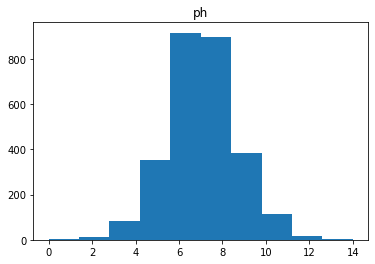

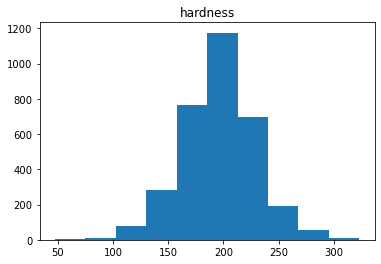

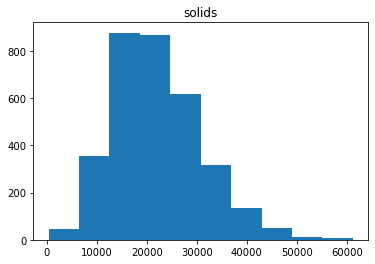

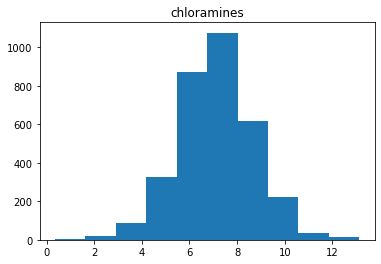

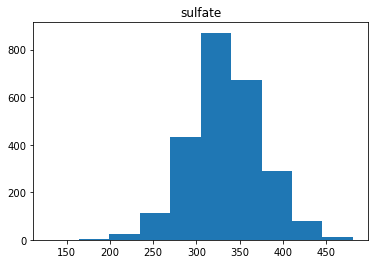

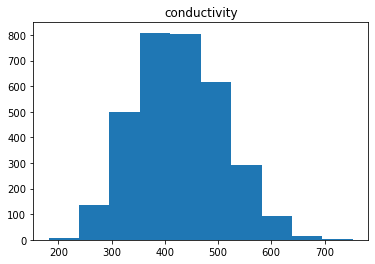

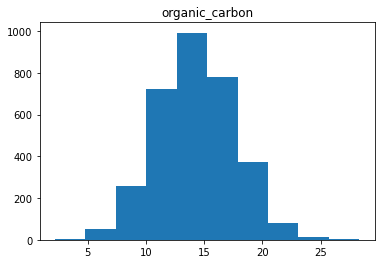

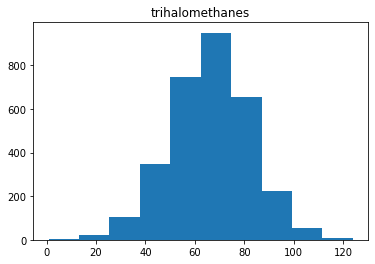

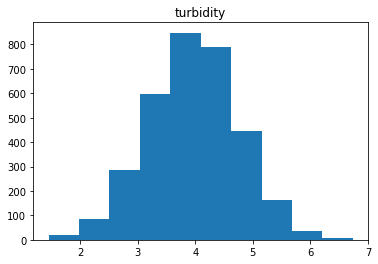

In [12]:
# Check the distributions - normal distributions
num_cols = df.columns[[df[col].dtype == 'float64' for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

In [13]:
obj_cols = df.columns[[df[col].dtype == 'int64' for col in df.columns]]

In [14]:
# describe object columns
for col in obj_cols:
    print(df[col].value_counts())
    print('----------------')
    print(df[col].value_counts(normalize=True, dropna=False))
    print('----------------')

0    1998
1    1278
Name: potability, dtype: int64
----------------
0    0.60989
1    0.39011
Name: potability, dtype: float64
----------------


In [15]:
# missing nulls
missing = df.isnull().sum()
missing[missing > 0]

ph                 491
sulfate            781
trihalomethanes    162
dtype: int64

In [16]:
df.dropna(inplace=True)

In [17]:
df.shape

(2011, 10)

In [18]:
# Baseline 0.596718
df.potability.value_counts(normalize=True)

0    0.596718
1    0.403282
Name: potability, dtype: float64

In [19]:
# seeing that dropping the nulls did not change much of the 0/1 results

### Takeways from data
 * potability is my target

### Split

Split the data to allow model to test on the data htat was not trained.  Way to gage how models will act in the real world with unseen data.

In [20]:
train, validate, test = prepare.split_data(df)

In [21]:
# Validate my split.

print(f'train -> {train.shape}')
print(f'validate -> {validate.shape}')
print(f'test -> {test.shape}')

train -> (1125, 10)
validate -> (483, 10)
test -> (403, 10)


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1125 entries, 2719 to 417
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               1125 non-null   float64
 1   hardness         1125 non-null   float64
 2   solids           1125 non-null   float64
 3   chloramines      1125 non-null   float64
 4   sulfate          1125 non-null   float64
 5   conductivity     1125 non-null   float64
 6   organic_carbon   1125 non-null   float64
 7   trihalomethanes  1125 non-null   float64
 8   turbidity        1125 non-null   float64
 9   potability       1125 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 96.7 KB


## Explore

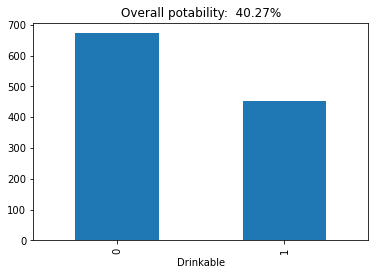

In [23]:
# Univariate 

train.potability.value_counts(normalize=False).plot.bar()

# annotate with the mean value in the title
potability_rate = train.potability.mean()
plt.title(f"Overall potability: {potability_rate: .2%}")
plt.xlabel("Drinkable")
plt.show()

<AxesSubplot:xlabel='potability', ylabel='solids'>

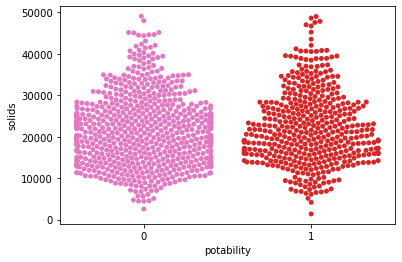

In [27]:
# Bivariate - potability and solids are pretty similar and might not play a large role in potability.

sns.swarmplot(x=train.potability, y=train.solids, palette='tab10_r')

<AxesSubplot:xlabel='potability', ylabel='ph'>

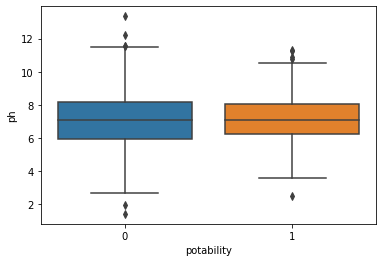

In [40]:
sns.boxplot(data=train, x='potability', y='ph')

<AxesSubplot:xlabel='potability', ylabel='hardness'>

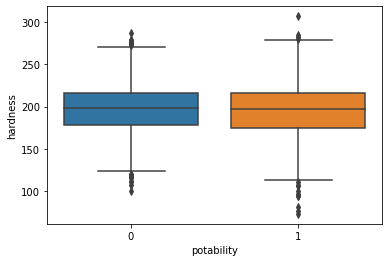

In [41]:
sns.boxplot(data=train, x='potability', y='hardness')

<AxesSubplot:xlabel='potability', ylabel='solids'>

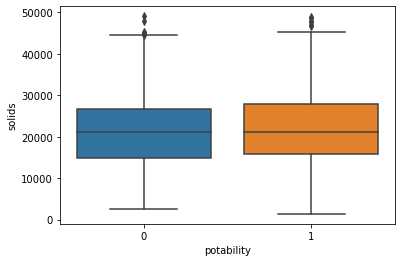

In [42]:
sns.boxplot(data=train, x='potability', y='solids')

<AxesSubplot:xlabel='potability', ylabel='chloramines'>

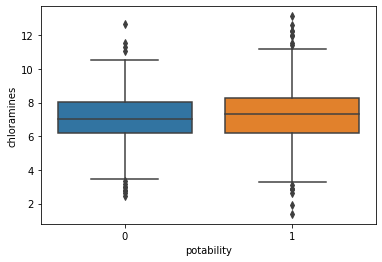

In [43]:
sns.boxplot(data=train, x='potability', y='chloramines')

<AxesSubplot:xlabel='potability', ylabel='sulfate'>

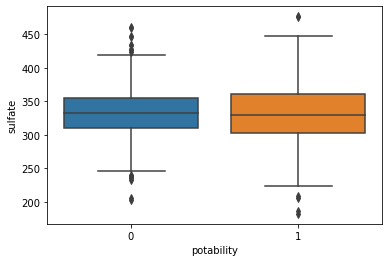

In [44]:
sns.boxplot(data=train, x='potability', y='sulfate')

<AxesSubplot:xlabel='potability', ylabel='conductivity'>

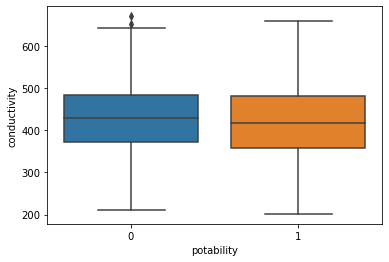

In [45]:
sns.boxplot(data=train, x='potability', y='conductivity')

<AxesSubplot:xlabel='potability', ylabel='organic_carbon'>

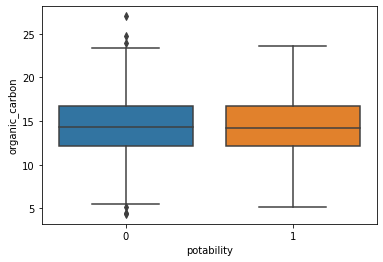

In [46]:
sns.boxplot(data=train, x='potability', y='organic_carbon')

<AxesSubplot:xlabel='potability', ylabel='trihalomethanes'>

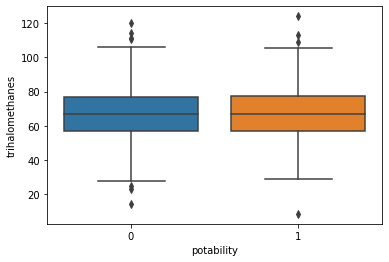

In [47]:
sns.boxplot(data=train, x='potability', y='trihalomethanes')

<AxesSubplot:xlabel='potability', ylabel='turbidity'>

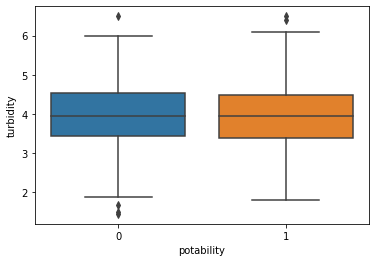

In [48]:
sns.boxplot(data=train, x='potability', y='turbidity')

In [50]:
# takeaways from boxplots - they all run about the same and alone do not give a clear represntation of what determines water potability

In [30]:
train.columns.to_list()

['ph',
 'hardness',
 'solids',
 'chloramines',
 'sulfate',
 'conductivity',
 'organic_carbon',
 'trihalomethanes',
 'turbidity',
 'potability']

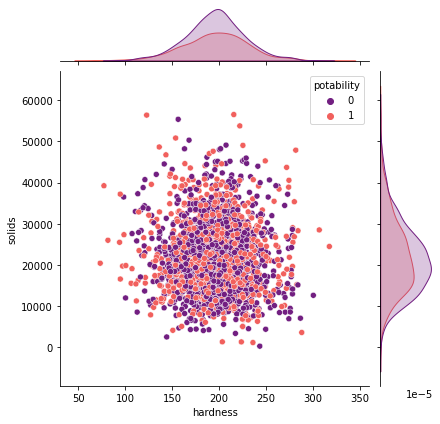

In [23]:
# Multivariate
sns.jointplot(data=df, x="hardness", y="solids", hue="potability", palette='magma')

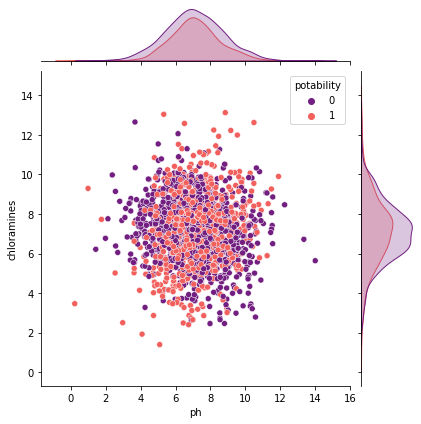

In [51]:
sns.jointplot(data=df, x="ph", y="chloramines", hue="potability", palette='magma')

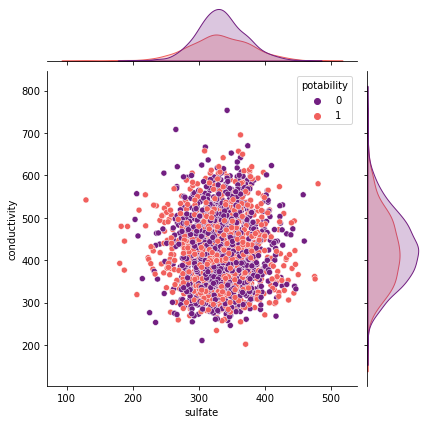

In [52]:
sns.jointplot(data=df, x="sulfate", y="conductivity", hue="potability", palette='magma')

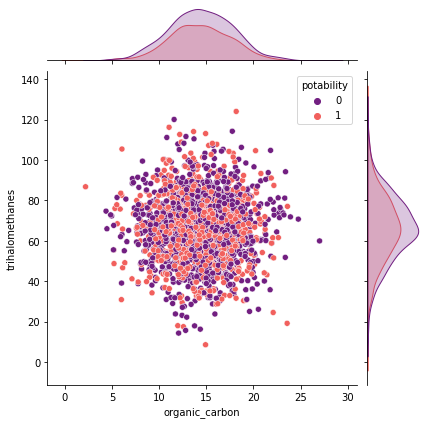

In [53]:
sns.jointplot(data=df, x="organic_carbon", y="trihalomethanes", hue="potability", palette='magma')

In [54]:
# very slight difference in each multivariate graph 

In [55]:
train.corr()[['potability']].sort_values(by = 'potability')

,potability
conductivity,-0.040478
hardness,-0.021968
sulfate,-0.019939
organic_carbon,-0.015944
turbidity,-0.004725
trihalomethanes,0.009623
ph,0.015771
solids,0.038645
chloramines,0.054815
potability,1.000000


### Hypothesis Testing

 * $H_o$: There is no association between solids and potability
 * $H_a$: There is an association between solids and potability

In [57]:
# Run two-sample ttest (one for 0 the other for 1 'potability')

In [62]:
# set our alpha
alpha = 0.05

In [64]:
target_0 = train[train['potability'] == 0]
target_1 = train[train['potability'] == 1]
test_results = stats.ttest_ind(target_0.solids, target_1.solids)
test_results

Ttest_indResult(statistic=-1.2960086084187772, pvalue=0.19523880842341945)

In [65]:
if test_results.pvalue < alpha:
    print('We reject the null')
else:
    print("we fail to reject the null")

we fail to reject the null


 * $H_o$: There is no association between conductivity and potability
 * $H_a$: There is an association between conductivity and potability

In [66]:
target_0 = train[train['potability'] == 0]
target_1 = train[train['potability'] == 1]
test_results = stats.ttest_ind(target_0.conductivity, target_1.conductivity)
test_results

Ttest_indResult(statistic=1.357578236821453, pvalue=0.17487028753211856)

In [67]:
if test_results.pvalue < alpha:
    print('We reject the null')
else:
    print("we fail to reject the null")

we fail to reject the null


In [94]:
# Exploration Takeaways
# shows the varables show light correlation but not much.  I will use modeling to further my investigation.

In [68]:
# setup for modeling

In [69]:
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['potability'])
y_train = train.potability

X_validate = validate.drop(columns=['potability'])
y_validate = validate.potability

X_test = test.drop(columns=['potability'])
y_test = test.potability

In [70]:
X_train.head(3)

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity
2719,9.038326,227.357659,34353.839725,5.573277,231.053687,421.664482,16.331421,92.643383,3.706266
3230,8.659113,114.807578,23514.636647,8.735315,333.027205,318.640679,16.559076,52.866373,2.895774
1502,9.917092,196.603746,37215.226835,7.408018,247.934855,522.548553,5.512040,77.830816,3.393325


## Modeling

In [75]:
# looking for an algorithm that beats the 60% accuracy shown on the value counts
train.potability.value_counts(normalize=True)

0    0.597333
1    0.402667
Name: potability, dtype: float64

In [77]:
# verifying the baseline using dummy classifier
baseline = DummyClassifier(strategy='constant', constant=0)

In [78]:
#Fit the object
baseline.fit(X_train, y_train)

DummyClassifier(constant=0, strategy='constant')

In [79]:
baseline_accuracy = baseline.score(X_train, y_train)
baseline_accuracy

0.5973333333333334

### Decision Tree

In [107]:
# set max depth to three
clf = DecisionTreeClassifier(max_depth=3, random_state=123)

fit, predict, score to find the accuracy score

In [108]:
# model.fit(X, y)
clf = clf.fit(X_train, y_train)

In [109]:
# visualize decision tree

In [110]:
clf.predict(X_train)

array([1, 0, 0, ..., 0, 0, 0])

In [111]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.64


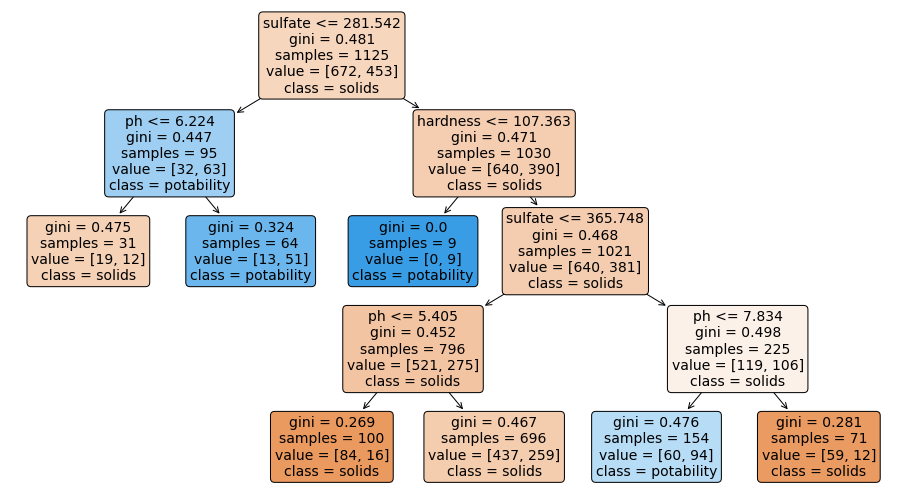

In [112]:
model = DecisionTreeClassifier(max_leaf_nodes=7)
model.fit(X_train, y_train)

plt.figure(figsize=(16, 9))
plot_tree(model, feature_names=X_train.columns.tolist(), class_names=['solids', 'potability'], filled=True, rounded=True)
plt.show()

In [113]:
pd.Series(dict(zip(X_train.columns, model.feature_importances_)))

ph                 0.559446
hardness           0.115984
solids             0.000000
chloramines        0.000000
sulfate            0.324570
conductivity       0.000000
organic_carbon     0.000000
trihalomethanes    0.000000
turbidity          0.000000
dtype: float64

<AxesSubplot:ylabel='Feature Importance'>

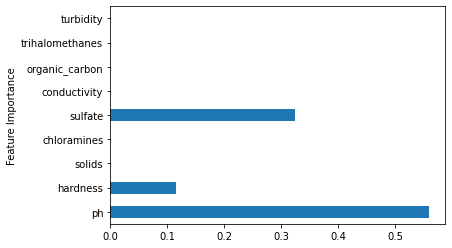

In [114]:
pd.Series(dict(zip(X_train.columns, model.feature_importances_))).plot.barh(xlabel='Feature Importance')

### Logistic Regression

In [137]:
# Create the logistic regression model using solids, conductivity, sulfate
logit = LogisticRegression(random_state=123)

# specify the features we're using
features = ["ph", "sulfate", "hardness"]

# Fit a model using only these specified features
# logit.fit(X_train[["age", "pclass", "fare"]], y_train)
logit.fit(X_train[features], y_train)

# Since we .fit on a subset, we .predict on that same subset of features
y_pred = logit.predict(X_train[features])

print("Baseline is", round(baseline_accuracy, 2))
print("Logistic Regression using ph, sulfate, and hardness features")
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train[features], y_train)))

Baseline is 0.6
Logistic Regression using ph, sulfate, and hardness features
Accuracy of Logistic Regression classifier on training set: 0.60


In [138]:
# Create the logistic regression
logit1 = LogisticRegression(random_state=123)

# specify the features we're using
features1 = ["solids", "conductivity", "turbidity"]

# Fit a model using only these specified features
logit1.fit(X_train[features], y_train)

y_pred = logit1.predict(X_train[features])

print("Logistic Regression using solids, conductivity, and turbidity features")
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit1.score(X_train[features], y_train)))

Logistic Regression using solids, conductivity, and turbidity features
Accuracy of Logistic Regression classifier on training set: 0.60


In [139]:
# both have the same accuracy - there are only slight correlations between each variable and the target.

In [140]:
# Now pick the best models and evaluate on Train and Validate!

In [141]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.64


In [142]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
      .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.61


In [143]:
print('Accuracy of Logistic Regression on training set: {:.2f}'
     .format(logit.score(X_train[features], y_train)))

Accuracy of Logistic Regression on training set: 0.60


In [144]:
print('Accuracy of Logistic Regression on validate set: {:.2f}'
     .format(logit.score(X_validate[features], y_validate)))

Accuracy of Logistic Regression on validate set: 0.60


In [145]:
# second logistic regression
print('Accuracy of Logistic Regression on training set: {:.2f}'
     .format(logit1.score(X_train[features1], y_train)))

Accuracy of Logistic Regression on training set: 0.40


In [147]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
      .format(logit1.score(X_validate[features1], y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.40


In [148]:
# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.96      0.75       288
           1       0.62      0.10      0.18       195

    accuracy                           0.61       483
   macro avg       0.62      0.53      0.46       483
weighted avg       0.62      0.61      0.52       483



In [ ]:
# run best model on test

In [150]:
clf.score(X_test, y_test)

0.6054590570719603

## Takeaways:
- Decision Tree ran the best model 
- Not able to predict a clear distinction between potable and non-potable based on the variables given

###  Recommendations & next steps:

 * I would like to collect data on microplastics in each body of water tested and predict how potabile the water would be with the microplastics.
 * With more time, I would have worked with more hyperparameters to improve the models